In [240]:
import json
import requests
import gzip
import shutil
import os
import math
import pickle

import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib.animation as animation

from copy import deepcopy

FFMpegWriter = animation.writers['ffmpeg']

# Some functions from SoccermaticsForPython

Some functions that will be useful taken from SoccermaticsForPython gitlab


In [207]:
def LoadDataHammarbyNewStructure2020(data_file_name, raw_dir):
    """
    Load and pre-process Signality data for a match, given a file location
    
    Returns
    -------
    ball_position
    
    players_position
    
    players_team_id_list
    
    events
    
    np.array(players_jersey)
    
    info
    
    players_names
    """
    print('Loading data, this might take some seconds...')
    
    info_dir = raw_dir+data_file_name+'-info_live.json'
    tracks_dir = raw_dir+data_file_name+'-tracks.json'
    events_dir = raw_dir+data_file_name+'-events.json'

    with open(info_dir) as json_data:
        info = json.load(json_data)

    with open(tracks_dir) as json_data:
        data = json.load(json_data)

    with open(events_dir) as json_data:
        events = json.load(json_data)
        
    # Add to info, so that is the same as the non-live
    info['home_team'] = {}
    info['home_team']['name'] = info['team_home_name']
    info['away_team'] = {}
    info['away_team']['name'] = info['team_away_name']

    #Get the track ids of all the players to establish the order in the rest of arrays
    order_list = []
    players_jersey = []
    players_names = []
    players_team_id = []
    players_team_id_list = []
   
    track_id = 0
    for player in info['team_home_players']:
        order_list.append(track_id)
        players_jersey.append(player['jersey_number'])
        players_names.append(player['name'])
        players_team_id.append(2)
        num_players_home = len(order_list)
        track_id += 1
    for player in info['team_away_players']:
        order_list.append(track_id)
        players_jersey.append(player['jersey_number'])
        players_names.append(player['name'])
        players_team_id.append(7)
        num_players_away = len(order_list)-num_players_home
        track_id += 1
        
    num_players_total = num_players_home+num_players_away
       
    #Create the lists of arrays
    players_position = []
    ball_position = []
    
    pitch_length = info['calibration']['pitch_size'][0]
    pitch_width = info['calibration']['pitch_size'][1]

    for frame in range(len(data)):
        #Get position of ball for each frame
        if data[frame]['ball'].get('position', np.asarray([np.inf,np.inf,np.inf])) is None:
            bp = np.asarray([np.inf, np.inf, np.inf])
        else:
            bp = np.asarray(data[frame]['ball'].get('position', np.asarray([np.inf,np.inf,np.inf])))
        bp = np.delete(bp,-1)
        bp[0] = (bp[0] + pitch_length / 2) / pitch_length
        bp[1] = (bp[1] + pitch_width / 2) / pitch_width
        ball_position.append(bp)

        #Append arrays of positions
        players_position.append(np.full((num_players_total,2),-1.0))
            
        # Get players
        # Home players
        for player in range(len(data[frame]['home_team'])):
            try:
                jersey_player = int(data[frame]['home_team'][player].get('jersey_number',-1))
                position_player = np.asarray(data[frame]['home_team'][player].get('position',np.asarray([-1,-1])))
            except:
                jersey_player = -1
                position_player = np.asarray([-1,-1])
            
            try:
                idx = players_jersey[:num_players_home].index(jersey_player)
                players_position[frame][idx][0] = (position_player[0]+pitch_length/2)/pitch_length
                players_position[frame][idx][1] = (position_player[1]+pitch_width/2)/pitch_width
            except:
                pass

                
        for player in range(len(data[frame]['away_team'])):
            try:
                jersey_player = int(data[frame]['away_team'][player].get('jersey_number',-1))
                position_player = np.asarray(data[frame]['away_team'][player].get('position',np.asarray([-1,-1])))
            except:
                jersey_player = -1
                position_player = np.asarray([-1,-1])
            
            try:
                idx = players_jersey[num_players_home:].index(jersey_player)+num_players_home
                players_position[frame][idx][0] = (position_player[0]+pitch_length/2)/pitch_length
                players_position[frame][idx][1] = (position_player[1]+pitch_width/2)/pitch_width
            except:
                pass
        
        players_team_id_list.append(np.array(players_team_id))

    print('Data has been loaded')
    
    return ball_position, players_position, players_team_id_list, events, np.array(players_jersey), info, players_names


def transform_coords(players_pos, ball_pos, pitch_dimensions=(104.6, 68.4):
    """
    Transform co-ordinates for ball and player positions:
    - First convert from a [0, 1] scale for length and width of the pitch to the 
      dimensions as specified by pitch_dimensions
    - Then convert so the centre spot is the origin
    
    Note: based on function taken from SoccermaticsForPython
    """
    pp = deepcopy(players_pos)
    bp = np.copy(ball_pos)
    x_dimension = pitch_dimensions[0]
    y_dimension = pitch_dimensions[1]
    
    for frame in range(len(players_pos)):
        pp[frame][:, 0] = players_pos[frame][:, 0] * x_dimension - x_dimension / 2
        pp[frame][:, 1] = y_dimension / 2 - players_pos[frame][:, 1] * y_dimension
        bp[frame][0] = ball_pos[frame][0] * x_dimension - x_dimension / 2
        bp[frame][1] = y_dimension / 2 - ball_pos[frame][1] * y_dimension

    return pp, bp

## Some functions taken or adapted from LaurieOnTracking

Some functions that will be useful taken from or adapted from LaurieOnTracking gitlab:
    https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

In [1253]:
def plot_pitch( field_dimen = (104.6, 68.4), field_color ='white', linewidth=2, markersize=20):
    """
    Adapted from code by Laurie Shaw in https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (104.6, 68.4), the dimensions of Hammerby's pitch.
        field_color: color of field. options are {'green', 'white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0] / 2. # length of half pitch
    half_pitch_width = field_dimen[1] / 2. # width of half pitch
    signs = [-1, 1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    
    return fig,ax


def plot_frame( hometeam, awayteam, ball, figax=None, team_colors=('r','b'), 
               field_dimen=(104.6, 68.4), include_player_velocities=False, 
               PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team, color in zip([hometeam, awayteam], team_colors):
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and team[c] > -(field_dimen[0] + 10) / 2] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and team[c] < (field_dimen[1] + 10) / 2] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha, z_order=2 ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns].astype(float), team[y_columns].astype(float), 
                      team[vx_columns].astype(float), team[vy_columns].astype(float), 
                      color=color, scale_units='inches', scale=10.,width=0.0015,
                      headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ax.text(team[x] + 1, team[y] + 1, x.split('_')[0], fontsize=10, color=color) for x, y in zip(x_columns, y_columns) if not (np.isnan(team[x]) or np.isnan(team[y]))] 
    # plot ball
    for _, bp in ball.iterrows():
        ax.plot(bp['ball_x'], bp['ball_y'], 'ko', MarkerSize=3, alpha=1.0, LineWidth=0, zorder=3)
        
    ax.plot(bp['ball_x'], bp['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0, zorder=1)
    plt.show()

    return fig,ax


def save_match_clip(hometeam, awayteam, ball, fpath, fname='clip_test', figax=None, frames_per_second=25, 
                    team_colors=('g','y'), field_dimen=(104.6, 68.4), include_player_velocities=True, 
                    PlayerMarkerSize=10, PlayerAlpha=0.7):
    """ save_match_clip( hometeam, awayteam, fpath )
    
    Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
    Parameters
    -----------
        hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
        awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
        fpath: directory to save the movie
        fname: movie filename. Default is 'clip_test.mp4'
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        frames_per_second: frames per second to assume when generating the movie. Default is 25.
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    assert np.all( hometeam.index==ball.index ), "Home and ball Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    
    print(fname)
    # create football pitch
    if figax is None:
        fig,ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig,ax = figax
    fig.set_tight_layout(True)
    # Generate movie
    print("Generating movie...",end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and team[c] > -(field_dimen[0] + 10) / 2] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and team[c] < (field_dimen[1] + 10) / 2] # column header for player y positions
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns].astype(float), team[y_columns].astype(float), 
                                     team[vx_columns].astype(float), team[vy_columns].astype(float), 
                                     color=color, scale_units='inches', scale=10.,width=0.0015,
                                     headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
            # plot ball
            objs, = ax.plot( ball.loc[i]['ball_x'], ball.loc[i]['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)

            writer.grab_frame()
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
    print("done")
    plt.clf()
    plt.close(fig)

## Functions to get Signality data into DataFrames

To make the results of the code from SoccermaticsForPython a bit easier to work with, we put tracking data for each team and for the ball into individual DataFrames

In [ ]:
def extract_positions_into_individual_fields(team_tracking_data):
    team_data = team_tracking_data.copy()
    for player in team_data.columns:
        team_data[[f'{player}_x', f'{player}_y']] = pd.DataFrame(team_data[player].tolist(),
                                                                 index=team_data.index)
        team_data = team_data.drop([player], axis=1)
    
    return team_data


def get_tracking_data_in_dataframes(players_position, players_jersey, team_index, ball_position):
    player_tracking_df = pd.DataFrame.from_records(players_position, columns=players_jersey)
    players_per_team = pd.DataFrame([{
        'player_jersey': jersey, 'team_id': team} for jersey, team in zip(players_jersey, players_team_id[0])
    ])
    
    home_team_tracking_data = player_tracking_df.iloc[:, np.where(team_index == 2)[0]].copy()
    home_team_tracking_data = extract_positions_into_individual_fields(home_team_tracking_data)
    
    away_team_tracking_data = player_tracking_df.iloc[:, np.where(team_index == 7)[0]].copy()
    away_team_tracking_data = extract_positions_into_individual_fields(away_team_tracking_data)
    
    ball_tracking_data = pd.DataFrame.from_records(ball_position, columns=['ball_x', 'ball_y'])
    
    return home_team_tracking_data, away_team_tracking_data, ball_tracking_data

## Do an initial plot for an arbitrary frame

Test out the functions above by getting data for one half for one match, putting it into DataFrames and then plotting a random frame from the match

In [204]:
file_name = '20190722.Hammarby-IFElfsborg'
#file_name = '20191020.Hammarby-MalmöFF'
#file_name = '20190930.Hammarby-Örebrö'
year = file_name[:4]

half_to_get_data_for = 1

data_file_name = f'{file_name}.{half_to_get_data_for}'

#Names of the teams playing in OPTA format
home_team_name = 'Hammarby IF'
away_team_name = 'IF Elfsborg'
color_home='g'
color_away='y'

#Preprocesses the file in to the format we use.
[ball_position_not_transf,players_position_not_transf,players_team_id,events,players_jersey,
 info_match,names_of_players] = LoadDataHammarbyNewStructure2020(data_file_name, 'Signality/2019/Tracking Data/')

players_in_play = GetPlayersInPlay(players_position_not_transf,frame)

players_position, ball_position = transform_coords(players_position_not_transf,
                                                  ball_position_not_transf)

Loading data, this might take some seconds...
Data has been loaded


In [714]:
# Get player jersey to name dictionary for each team
home_players = {jersey: name for jersey, name in zip(players_jersey[team_index==2], 
                                                     np.array(names_of_players)[team_index==2])}
away_players = {jersey: name for jersey, name in zip(players_jersey[team_index==7], 
                                                     np.array(names_of_players)[team_index==7])}

In [1001]:
home_team_tracking_data, away_team_tracking_data, ball_tracking_data = get_tracking_data_in_dataframes(players_position, 
                                                                                                       players_jersey, 
                                                                                                       team_index, 
                                                                                                       ball_position)

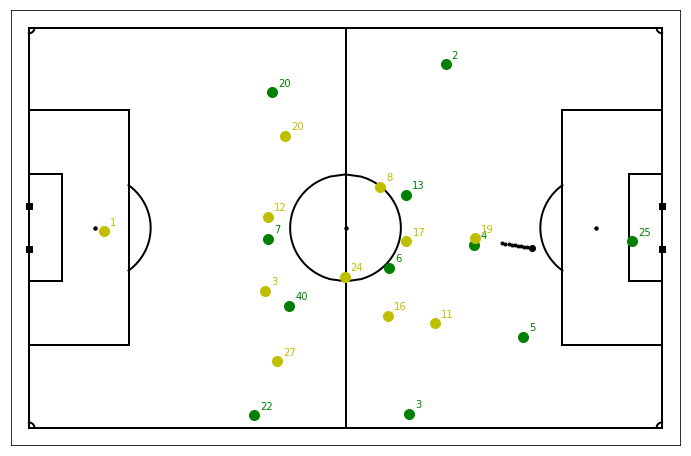

(<matplotlib.figure.Figure at 0x13f9e8beb38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f9e8db9e8>)

In [1002]:
plot_frame(home_team_tracking_data.loc[1000], away_team_tracking_data.loc[1000], 
           ball_tracking_data.loc[990: 1000], team_colors=(color_home, color_away), 
           annotate=True, PlayerAlpha=1)

# Get player metrics

From the tracking data, derive:

* distance of players from goal
* velocity of players in x and y direction
* speed of players
* acceleration of players in x and y direction
* magnitude of acceleration
* distance between each player and nearest oppostion player
* distance between each player and nearest teammate

In [247]:
def remove_player_velocities(team):
    # remove player velocoties and acceleeration measures that are already in the 'team' dataframe
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']]
    team = team.drop(columns, axis=1)
    return team


def calc_player_velocities(team, dt=0.04, smoothing=True, filter_type='Savitzky-Golay', window=7, 
                           polyorder=1, maxspeed=12):
    """
    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        dt: the time window between measurements. Default is 0.04 (ie, 25 measurements per second)
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    # remove any velocity data already in the dataframe
    team = remove_player_velocities(team)
    
    # Get the player ids
    player_ids = np.unique([c[:-2] for c in team.columns])

    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player + "_x"].diff() / dt
        vy = team[player + "_y"].diff() / dt

        if maxspeed > 0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[raw_speed > maxspeed] = np.nan
            vy[raw_speed > maxspeed] = np.nan
            
        if smoothing:
            if filter_type == 'Savitzky-Golay':
                vx = signal.savgol_filter(vx, window_length=window, polyorder=polyorder)
                vy = signal.savgol_filter(vy, window_length=window, polyorder=polyorder)        
            elif filter_type == 'moving_average':
                ma_window = np.ones(window) / window 
                vx = np.convolve(vx, ma_window, mode='same') 
                vy = np.convolve(vy, ma_window, mode='same')      
        
        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt(vx**2 + vy**2)

    return team

In [1003]:
home_tracking_with_speed = calc_player_velocities(home_team_tracking_data, filter_type='moving_average')
away_tracking_with_speed = calc_player_velocities(away_team_tracking_data, filter_type='moving_average')

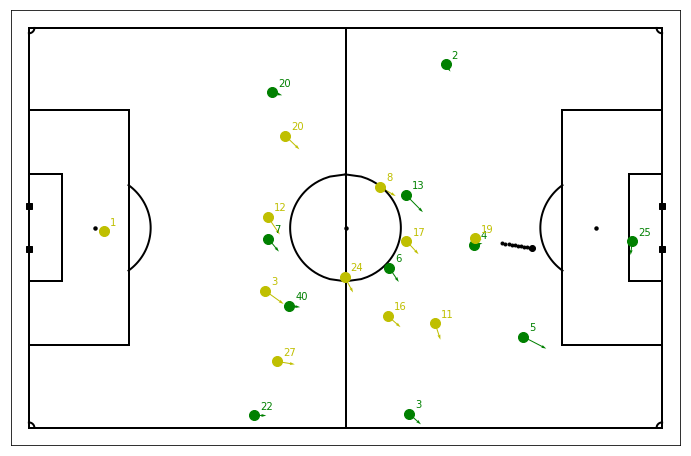

(<matplotlib.figure.Figure at 0x13f9cf480f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f9d3bbe48>)

In [1004]:
frame_to_plot = 1000

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

## Make a movie showing the 8 seconds leading up to frame 1000

In [296]:
save_match_clip(home_tracking_with_speed[800:1000], away_tracking_with_speed[800:1000], 
                ball_tracking_data[800:1000], fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data', fname='clip_test')

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/clip_test.mp4
Generating movie...done


In [1005]:
def calculate_acceleration(team_data, dt=0.04, smoothing=True, filter_type='Savitzky-Golay', window=7, 
                           polyorder=1, maxacc=None):
    
    team_data = team_data.copy()
    player_ids = np.unique([c.split('_')[0] for c in team_data.columns])
    for player in player_ids:
        ax = team_data[f'{player}_vx'].diff() / dt
        ay = team_data[f'{player}_vy'].diff() / dt
        acceleration = team_data[f'{player}_speed'].diff() / dt
        
        if maxacc:
            raw_acc = np.sqrt(ax**2 + ay**2)
            ax[raw_acc > maxacc] = np.nan
            ay[raw_acc > maxacc] = np.nan
        
        if smoothing:
            if filter_type == 'Savitzky-Golay':
                ax = signal.savgol_filter(ax, window_length=window, polyorder=polyorder)
                ay = signal.savgol_filter(ay, window_length=window, polyorder=polyorder)
                acceleration = signal.savgol_filter(acceleration, window_length=window, polyorder=polyorder)
            elif filter_type == 'moving_average':
                ma_window = np.ones(window) / window 
                ax = np.convolve(ax, ma_window, mode='same') 
                ay = np.convolve(ay, ma_window, mode='same')
                acceleration = np.convolve(acceleration, ma_window, mode='same')
        
        team_data[player + "_ax"] = ax
        team_data[player + "_ay"] = ay
        team_data[player + "_acceleration"] = acceleration
        
    return team_data

In [1006]:
home_tracking_with_acceleration = calculate_acceleration(home_tracking_with_speed,
                                                         filter_type='moving_average')
away_tracking_with_acceleration = calculate_acceleration(away_tracking_with_speed,
                                                         filter_type='moving_average')

In [393]:
# Check top acceleration for each player
# top_acceleration = []
# for player in np.unique([c.split('_')[0] for c in home_tracking_with_acceleration.columns]):
#     player_top_acceleration = np.amax(home_tracking_with_acceleration[player + '_acceleration'])
#     top_acceleration.append({f'player with jersey number {player}': player_top_acceleration})

# top_acceleration

In [1007]:
def calculate_distance_to_goal(team_data, left_to_right, pitch_dimensions=(104.6, 68.4)):
    
    team_data = team_data.copy()
    player_ids = np.unique([c.split('_')[0] for c in team_data.columns])
    if left_to_right:
        goal_x = pitch_dimensions[0] / 2
    else:
        goal_x = - pitch_dimensions[0] / 2
    
    for player in player_ids:
        x_displacement_to_goal = goal_x - team_data[f'{player}_x']
        y_displacement_to_goal = team_data[f'{player}_y']
        distance_to_goal = np.sqrt(x_displacement_to_goal ** 2 + y_displacement_to_goal ** 2)
        
        team_data[f'{player}_distance_to_goal'] = distance_to_goal
    
    return team_data

In [1008]:
home_tracking_with_distance_to_goal = calculate_distance_to_goal(home_tracking_with_acceleration,
                                                                 left_to_right=False)
away_tracking_with_distance_to_goal = calculate_distance_to_goal(away_tracking_with_acceleration,
                                                                 left_to_right=True)

In [1178]:
def plot_speed_acceleration_distance_scatter(team_data, player_to_plot, start_frame, player_lookup, 
                                             seconds_to_plot=15, speed_plot_y_axis_limits=None,
                                             distance_plot_y_axis_limits=None, events_to_plot=None):
    """
    Produce a speed acceleration plot and a distance from goal plot for given player in 
    team, given a start frame and number of seconds to plot
    """
    
    end_frame = start_frame + 25 * seconds_to_plot + 1
    player_name = player_lookup[int(player_to_plot)]
    fig, ax = plt.subplots(nrows=2, ncols=1)
    
    fig.set_facecolor('#333333')
    for a in [0, 1]:
        ax[a].set_facecolor('#333333')
        ax[a].spines["bottom"].set_color("white")
        ax[a].spines["left"].set_color("white")
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        ax[a].tick_params(axis='x', colors='white')
        ax[a].tick_params(axis='y', colors='white')

    for metric, color in [['speed', '#ceb1fc'], ['acceleration', '#b1cefc']]:
        ax[0].plot(range(start_frame, end_frame), 
                   team_data[start_frame : end_frame][f'{player_to_plot}_{metric}'],
                   color=color, label=metric.replace('_', ' '))

    ax[0].set_xticks(range(start_frame, end_frame, 25))
    ax[0].set_xticklabels(range(0, seconds_to_plot + 1))
    fig.text(0.18, 0.95, "Speed", ha="right", va="bottom", fontsize='large', color="#ceb1fc")
    fig.text(0.18, 0.95, " and", ha="left", va="bottom", fontsize='large', color='white')
    fig.text(0.43, 0.95, "acceleration", ha="right", va="bottom", fontsize='large', color="#b1cefc")
    fig.text(0.43,0.95, f" over 15 seconds, for {player_name}", ha="left", va="bottom", fontsize='large', color="white")
    if speed_plot_y_axis_limits:
        ax[0].set_ylim(speed_plot_y_axis_limits[0], speed_plot_y_axis_limits[1])
    
    fig.text(0.4, 0.46, "Distance from goal", ha="right", va="bottom", fontsize='large', color="#fcceb1")
    fig.text(0.4, 0.46, f" over 15 seconds, for {player_name}", ha="left", va="bottom", fontsize='large', color='white')
    
    ax[1].plot(range(start_frame, end_frame), 
               team_data[start_frame : end_frame][f'{player_to_plot}_distance_to_goal'],
               label='distance to goal', color='#fcceb1')
    ax[1].set_xticks(range(start_frame, end_frame, 25))
    ax[1].set_xticklabels(range(0, seconds_to_plot + 1))
    if speed_plot_y_axis_limits:
        ax[1].set_ylim(distance_plot_y_axis_limits[0], distance_plot_y_axis_limits[1])
    
    if events_to_plot:
        for a in [0, 1]:
            y_max = ax[a].get_ylim()[-1]
            y_min = ax[a].get_ylim()[0]
            y_range = y_max - y_min
            for event_frame, event_type in events_to_plot.items():
                ax[a].vlines(event_frame, y_min, y_max, color='#F0DCB4', linestyle='--', alpha=0.5)
                ax[a].annotate(event_type, (event_frame, y_min ), color='#F0DCB4')
    
    fig.tight_layout()
    
    plt.show()

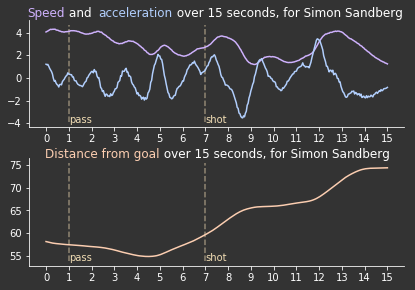

In [1179]:
start_frame = 625
player_to_plot = 2

plot_speed_acceleration_distance_scatter(home_tracking_with_distance_to_goal, 2, 625, home_players,
                                        events_to_plot={650: 'pass', 800: 'shot'})

In [1011]:
def calculate_distance_to_nearest_oppostion_player(team_1_data, team_2_data):
    team_1_data = team_1_data.copy()
    team_2_data = team_2_data.copy()
    
    team_1_ids = np.unique([c.split('_')[0] for c in team_1_data.columns])
    team_2_ids = np.unique([c.split('_')[0] for c in team_2_data.columns])
    
    for player in team_1_ids:
        player_df = pd.DataFrame(index=team_1_data.index)
        for team_2_player in team_2_ids:
            dx = team_1_data[f'{player}_x'] - team_2_data[f'{team_2_player}_x']
            dy = team_1_data[f'{player}_y'] - team_2_data[f'{team_2_player}_y']
            distance = np.sqrt(dx ** 2 + dy ** 2)
        
            player_df[f'{player}_distance_to_opposition_{team_2_player}'] = distance

        min_distance = player_df.min(axis=1)
        nearest_opponenet = player_df.idxmin(axis=1).apply(lambda x: x.split('_')[-1])
        team_1_data[f'{player}_distance_to_nearest_opponent'] = min_distance
        team_1_data[f'{player}_nearest_opponent'] = nearest_opponenet 
        
    return team_1_data

In [1012]:
home_tracking_with_nearest_opposition = calculate_distance_to_nearest_oppostion_player(home_tracking_with_distance_to_goal,
                                                                                     away_tracking_with_distance_to_goal)
away_tracking_with_nearest_opposition = calculate_distance_to_nearest_oppostion_player(away_tracking_with_distance_to_goal,
                                                                                     home_tracking_with_distance_to_goal)

In [643]:
home_tracking_with_nearest_opposition.loc[1000:1000]

,27_x,27_y,11_x,11_y,14_x,14_y,16_x,16_y,23_x,23_y,...,40_distance_to_nearest_opponent,40_nearest_opponent,5_distance_to_nearest_opponent,5_nearest_opponent,6_distance_to_nearest_opponent,6_nearest_opponent,7_distance_to_nearest_opponent,7_nearest_opponent,77_distance_to_nearest_opponent,77_nearest_opponent
1000,-156.9,102.6,-156.9,102.6,-156.9,102.6,-156.9,102.6,-156.9,102.6,...,4.715422,3,14.773304,11,5.389063,17,3.720659,12,0.0,10


In [1013]:
def calculate_distance_to_nearest_teammate(team_data):
    team_data = team_data.copy()
    
    team_ids = np.unique([c.split('_')[0] for c in team_data.columns])
    
    for player in team_ids:
        player_df = pd.DataFrame(index=team_data.index)
        for other_player in team_ids:
            if other_player == player:
                continue
            dx = team_data[f'{player}_x'] - team_data[f'{other_player}_x']
            dy = team_data[f'{player}_y'] - team_data[f'{other_player}_y']
            distance = np.sqrt(dx ** 2 + dy ** 2)
        
            player_df[f'{player}_distance_to_{other_player}'] = distance

        min_distance = player_df.min(axis=1)
        nearest_teammate = player_df.idxmin(axis=1).apply(lambda x: x.split('_')[-1])
        team_data[f'{player}_distance_to_nearest_teammate'] = min_distance
        team_data[f'{player}_nearest_teammate'] = nearest_teammate 
        
    return team_data

In [1014]:
home_tracking_with_nearest_teammate = calculate_distance_to_nearest_teammate(home_tracking_with_nearest_opposition)
away_tracking_with_nearest_teammate = calculate_distance_to_nearest_teammate(away_tracking_with_nearest_opposition)

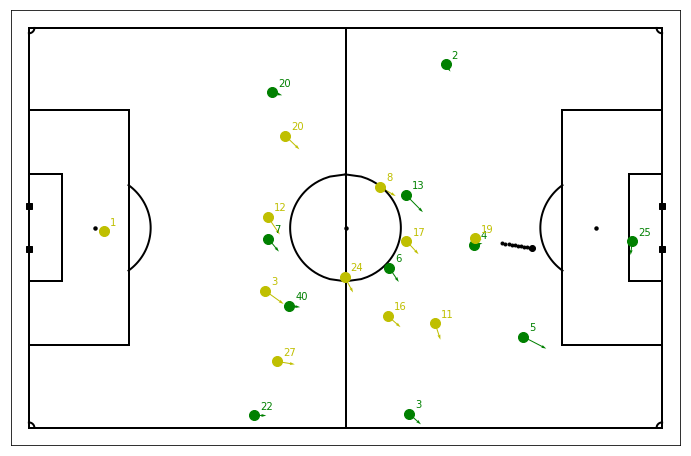

(<matplotlib.figure.Figure at 0x13fc0a17f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fa72472e8>)

In [650]:
frame_to_plot = 1000

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

In [663]:
def save_movie(start_frame, clip_length, file_name):
    end_frame = start_frame + clip_length * 25
    save_match_clip(home_tracking_with_speed[start_frame:end_frame], 
                    away_tracking_with_speed[start_frame:end_frame], 
                    ball_tracking_data[start_frame:end_frame], 
                    fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data', 
                    fname=file_name)

In [664]:
# First goal - 18th minute. Good runs by 
save_movie(26500, 20, 'first_goal')

# Second goal - 28th minute. Own goal from freekick, harder to evaluate

# Third goal - 31st minute. Good through run by player 
save_movie(45000, 15, 'third_goal')

# Fourth goal - 39th minute
save_movie(57125, 15, 'fourth_goal')

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/first_goal.mp4
Generating movie...done


In [1210]:
# Game vs Malmo, good team goal in 15th minute

In [667]:
26500 + 11 * 25

26775

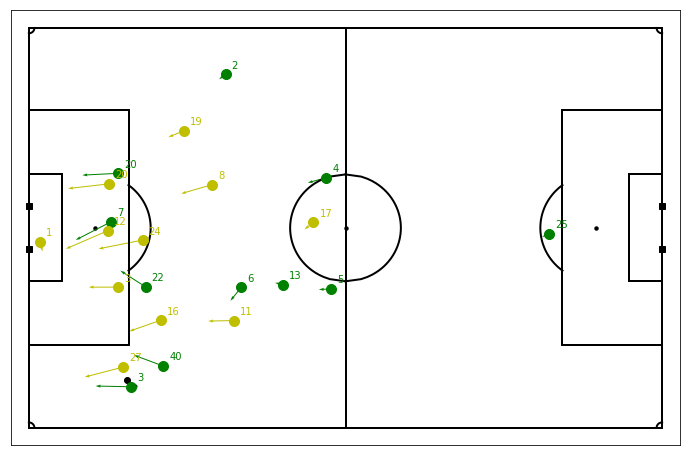

(<matplotlib.figure.Figure at 0x13fb97bcda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fecd07940>)

In [1197]:
# First goal, run by player 40 to occupy valuable space in area
# Player 20 making run into space in centre of box
# So opposition player 20 can't fully track player 7 who is starting to think about a cross from player 40 
frame_to_plot = 26755

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, 'y'), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

In [776]:
home_players[22]

'Muamer Tankovic'

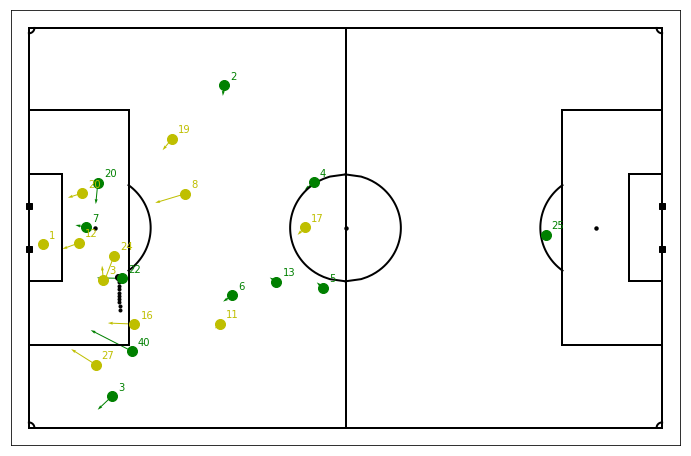

(<matplotlib.figure.Figure at 0x13f8e4faac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f8dd729e8>)

In [673]:
# First goal, run by player 40 to occupy valuable space in area
# Player 20 making run into space in centre of box
# So opposition player 20 can't fully track player 7 who is starting to think about a cross from player 40 
frame_to_plot = 26782

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

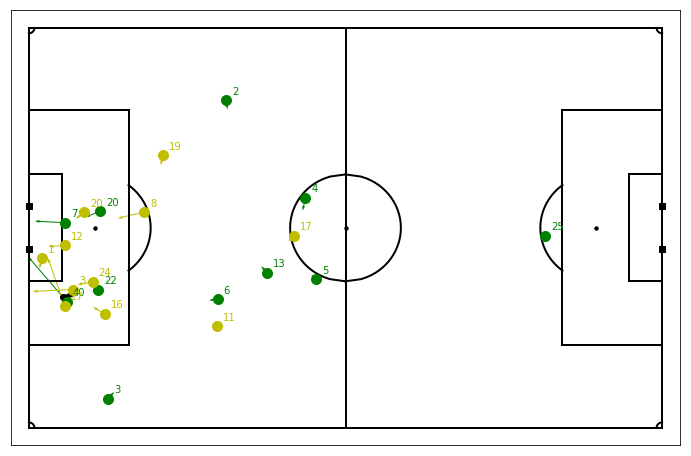

(<matplotlib.figure.Figure at 0x13ffcde42e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14003773a90>)

In [680]:
# First goal, run by player 7 into high xG space
# Player 20's run into the centre of the box has drawn opposition player 20 to him
# Player 7's run behind player 12 is unchecked and he's able to find a very high xG location to tap in a cross
frame_to_plot = 26829

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

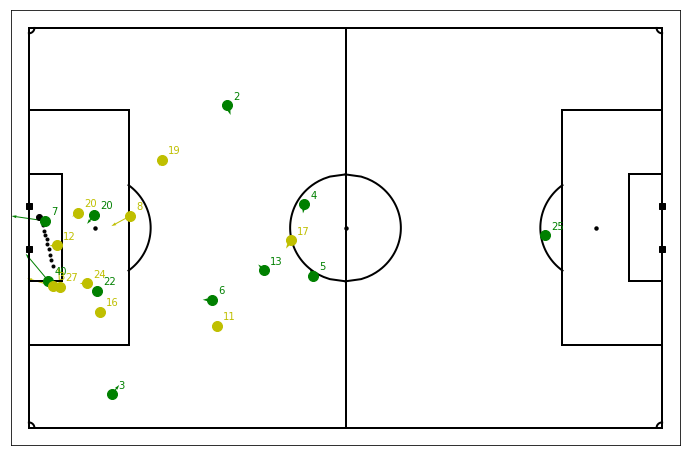

(<matplotlib.figure.Figure at 0x13f9cd6f6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fa030ae10>)

In [983]:
# First goal, run by player 7 into high xG space
# Player 20's run into the centre of the box has drawn opposition player 20 to him
# Player 7's run behind player 12 is unchecked and he's able to find a very high xG location to tap in a cross
frame_to_plot = 26846

plot_frame(home_tracking_with_speed.loc[frame_to_plot], away_tracking_with_speed.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

In [693]:
26852 - 15 * 25

26477

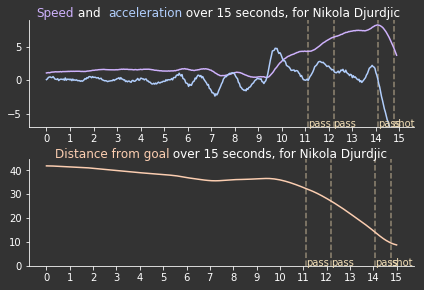

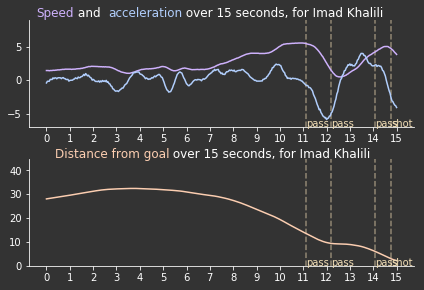

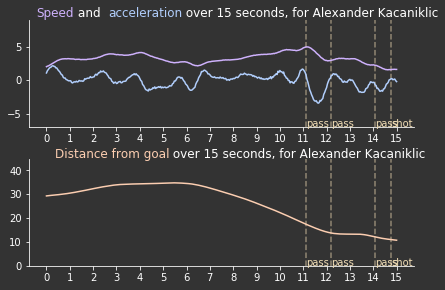

In [1180]:
start_frame = 26477
players_to_plot = [40, 7, 20]
plot_1_y_axis = [-7, 9]
plot_2_y_axis = [0, 45]
event_for_plot = {
    26755: 'pass',
    26782: 'pass',
    26829: 'pass',
    26846: 'shot'
}

for player in players_to_plot:
    plot_speed_acceleration_distance_scatter(home_tracking_with_distance_to_goal, player, start_frame, 
                                             home_players, speed_plot_y_axis_limits=plot_1_y_axis,
                                             distance_plot_y_axis_limits=plot_2_y_axis,
                                             events_to_plot=event_for_plot)

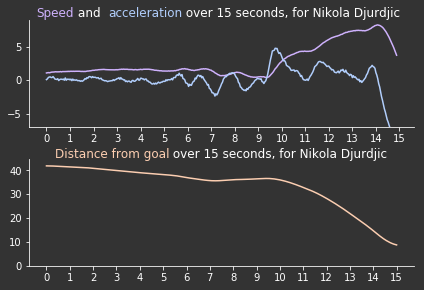

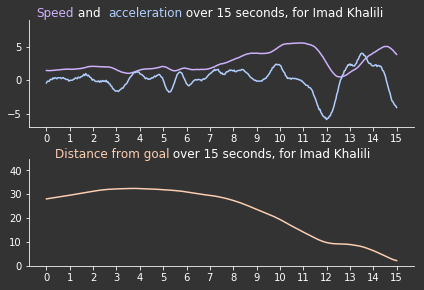

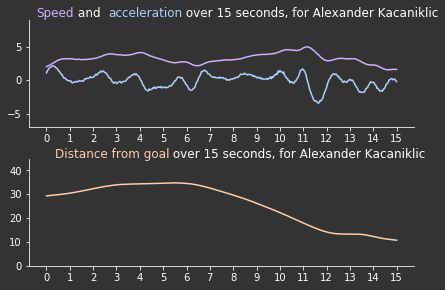

In [1198]:
start_frame = 26477
players_to_plot = [40, 7, 20]
plot_1_y_axis = [-7, 9]
plot_2_y_axis = [0, 45]
for player in players_to_plot:
    plot_speed_acceleration_distance_scatter(home_tracking_with_distance_to_goal, player, start_frame, 
                                             home_players, speed_plot_y_axis_limits=plot_1_y_axis,
                                             distance_plot_y_axis_limits=plot_2_y_axis)

In [833]:
def plot_distance_to_nearest_player(team_data, player_to_plot, start_frame, player_lookup,
                                    opponent_or_teammate='opponent', seconds_to_plot=15, 
                                    y_axis_limits=None):
    """
    Produce a speed acceleration plot and a distance from goal plot for given player in 
    team, given a start frame and number of seconds to plot
    """
    
    end_frame = start_frame + 25 * seconds_to_plot + 1
    player_name = player_lookup[int(player_to_plot)]
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    fig.set_facecolor('#333333')
    ax.set_facecolor('#333333')
    ax.spines["bottom"].set_color("white")
    ax.spines["left"].set_color("white")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    ax.plot(range(start_frame, end_frame), 
            team_data[start_frame : end_frame][f'{player_to_plot}_distance_to_nearest_{opponent_or_teammate}'],
            color='#b1fcce')
    
#     fig.text(0.5, 0.95, f"Distance to nearest {opponent_or_teammate}", ha="right", va="bottom", fontsize='large', color="#b1fcce")
#     fig.text(0.5, 0.95, f" over 15s, for {player_name}", ha="left", va="bottom", fontsize='large', color='white')
    ax.set_title(f'Distance between Khalili and Kacaniklic',
                  color='white')
    ax.set_xticks(range(start_frame, end_frame, 25))
    ax.set_xticklabels(range(0, seconds_to_plot + 1))
    if y_axis_limits:
        ax.set_ylim(y_axis_limits[0], y_axis_limits[1])
    
    fig.tight_layout()
    
    plt.show()

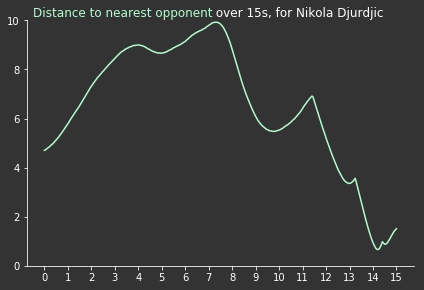

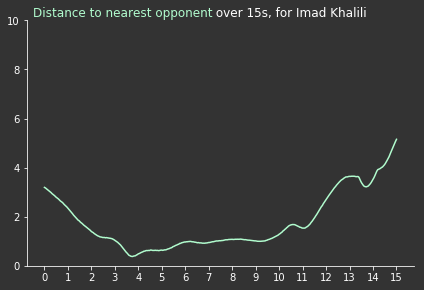

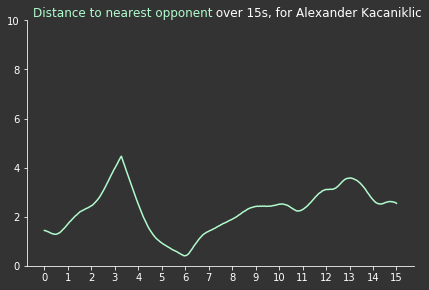

In [821]:
start_frame = 26477
players_to_plot = [40, 7, 20]
y_axis_limits = [0, 10]
for player in players_to_plot:
    plot_distance_to_nearest_player(home_tracking_with_nearest_teammate, player, start_frame,
                                    home_players, y_axis_limits=y_axis_limits)

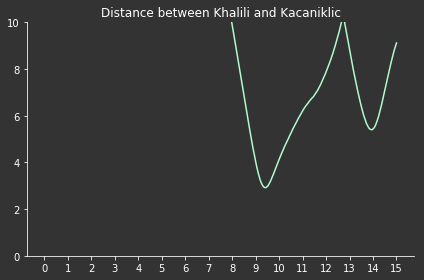

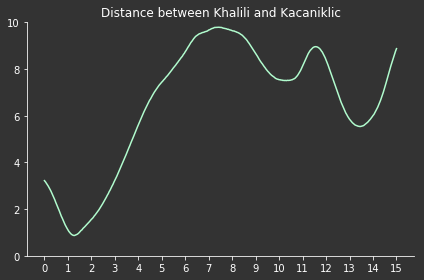

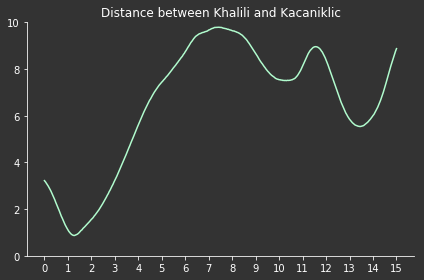

In [834]:
start_frame = 26477
players_to_plot = [40, 7, 20]
y_axis_limits = [0, 10]
for player in players_to_plot:
    plot_distance_to_nearest_player(home_tracking_with_nearest_teammate, player, start_frame,
                                    home_players, opponent_or_teammate='teammate', 
                                    y_axis_limits=y_axis_limits)

The space that Khalili and Kacaniklic create for themselves with good movement in the box in the build up to the goal is the key here. If only one of them is moving into dangerous space then the defender's job is easier. But they both create space is high xG areas. Ultimately opposition player 20 is in no-mans-land and is placed almost exactly between the two players. It is also notable that the two players keep a distance of approx 8m between themselves, so both cannot be successfully marked by the sinlge opposition defender. 

As all of this is happening, opposition players scramble to close down Djurdjic. His run has put him into a dangerous scoring position and the keeper closes him down making an already challenging chance, thanks to the angle, even more difficult. He is aware enough to see the movement in the center from Khalili and Kacaniklic and picks out Khalili who is left with a simple tap-in to score

In [830]:
def plot_speed_acceleration_distance_nearest(team_data, player_to_plot, start_frame, player_lookup, 
                                             seconds_to_plot=15, speed_plot_y_axis_limits=None,
                                             distance_plot_y_axis_limits=None, nearest_opponent_y_axis_limits=None):
    """
    Produce a speed acceleration plot and a distance from goal plot for given player in 
    team, given a start frame and number of seconds to plot
    """
    
    end_frame = start_frame + 25 * seconds_to_plot + 1
    player_name = player_lookup[int(player_to_plot)]
    fig, ax = plt.subplots(nrows=3, ncols=1)
    
    fig.set_facecolor('#333333')
    fig.set_size_inches(5, 7)
    for a in [0, 1, 2]:
        ax[a].set_facecolor('#333333')
        ax[a].spines["bottom"].set_color("white")
        ax[a].spines["left"].set_color("white")
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        ax[a].tick_params(axis='x', colors='white')
        ax[a].tick_params(axis='y', colors='white')

    for metric, color in [['speed', '#ceb1fc'], ['acceleration', '#b1cefc']]:
        ax[0].plot(range(start_frame, end_frame), 
                   team_data[start_frame : end_frame][f'{player_to_plot}_{metric}'],
                   color=color, label=metric.replace('_', ' '))

    ax[0].set_xticks(range(start_frame, end_frame, 25))
    ax[0].set_xticklabels(range(0, seconds_to_plot + 1))
    fig.text(0.15, 0.97, "Speed", ha="right", va="bottom", fontsize='medium', color="#ceb1fc")
    fig.text(0.15, 0.97, " and", ha="left", va="bottom", fontsize='medium', color='white')
    fig.text(0.4, 0.97, "acceleration", ha="right", va="bottom", fontsize='medium', color="#b1cefc")
    fig.text(0.4, 0.97, f" over 15 seconds, for {player_name}", ha="left", va="bottom", fontsize='medium', color="white")
    if speed_plot_y_axis_limits:
        ax[0].set_ylim(speed_plot_y_axis_limits[0], speed_plot_y_axis_limits[1])
    
    fig.text(0.38, 0.64, "Distance from goal", ha="right", va="bottom", fontsize='medium', color="#fcceb1")
    fig.text(0.38, 0.64, f" over 15 seconds, for {player_name}", ha="left", va="bottom", fontsize='medium', color='white')
    
    ax[1].plot(range(start_frame, end_frame), 
               team_data[start_frame : end_frame][f'{player_to_plot}_distance_to_goal'],
               label='distance to goal', color='#fcceb1')
    ax[1].set_xticks(range(start_frame, end_frame, 25))
    ax[1].set_xticklabels(range(0, seconds_to_plot + 1))
    if speed_plot_y_axis_limits:
        ax[1].set_ylim(distance_plot_y_axis_limits[0], distance_plot_y_axis_limits[1])
    
    ax[2].plot(range(start_frame, end_frame), 
            team_data[start_frame : end_frame][f'{player_to_plot}_distance_to_nearest_opponent'],
            color='#b1fcce')
    
    fig.text(0.5, 0.32, f"Distance to nearest opponent", ha="right", va="bottom", fontsize='medium', color="#b1fcce")
    fig.text(0.5, 0.32, f" over 15s, for {player_name}", ha="left", va="bottom", fontsize='medium', color='white')
#     ax.set_title(f'Distance between {player_name} and nearest {opponent_or_teammate}',
#                   color='white')
    ax[2].set_xticks(range(start_frame, end_frame, 25))
    ax[2].set_xticklabels(range(0, seconds_to_plot + 1))
    if nearest_opponent_y_axis_limits:
        ax[2].set_ylim(nearest_opponent_y_axis_limits[0], nearest_opponent_y_axis_limits[1])
    
    fig.tight_layout()
    
    plt.show()

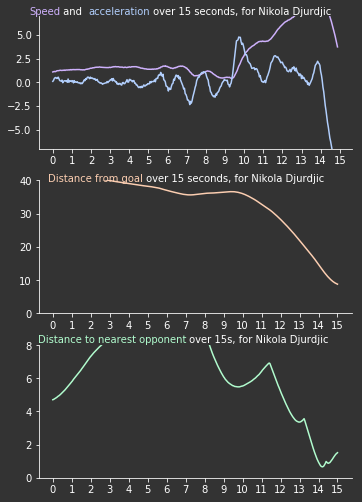

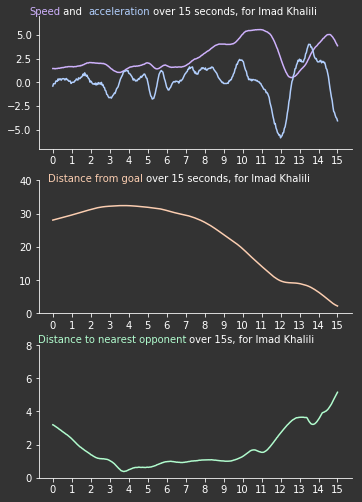

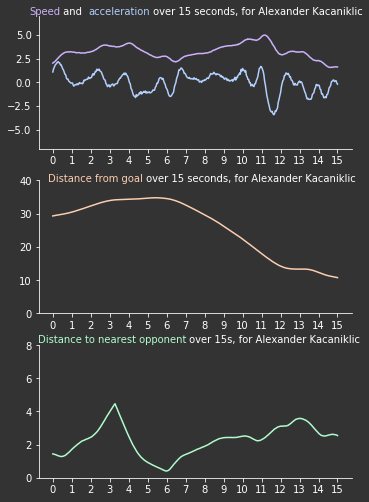

In [832]:
start_frame = 26477
players_to_plot = [40, 7, 20]
plot_1_y_axis = [-7, 7]
plot_2_y_axis = [0, 40]
plot_3_y_axis = [0, 8]
for player in players_to_plot:
    plot_speed_acceleration_distance_nearest(home_tracking_with_nearest_teammate, player, start_frame, 
                                             home_players, speed_plot_y_axis_limits=plot_1_y_axis,
                                             distance_plot_y_axis_limits=plot_2_y_axis,
                                             nearest_opponent_y_axis_limits=plot_3_y_axis)

In [852]:
pids = np.unique([c.split('_')[0] for c in home_team_tracking_data.columns])
    
for player in pids:
    x_diff = home_team_tracking_data[f'{player}_x'].diff()
    y_diff = home_team_tracking_data[f'{player}_y'].diff()
    jump_in_x_diff = x_diff[x_diff > 5]
    jump_in_y_diff = y_diff[y_diff > 5]
    if len(jump_in_x_diff) > 0 or len(jump_in_y_diff) > 0:
        print('################')
        print(player)
        print(jump_in_x_diff)
        

################
13
2        166.79
4620     126.95
5244     128.84
7501     192.83
7516     193.10
8602     195.15
8616     197.44
8679     197.65
8794     189.36
8802     188.76
14009    174.99
28746    183.08
28773    180.46
28896    181.15
39635    156.92
41073    117.72
43784    173.67
54654    202.11
55193    190.93
57995    135.20
64012    204.03
64245    197.63
64252    197.14
68201    181.20
68994    156.11
69000    154.80
Name: 13_x, dtype: float64
################
2
3        172.33
8683     196.78
11078    174.85
11172    173.23
11330    170.08
11649    198.17
18693    128.25
18793     18.83
23247    151.80
24193    163.25
27369    123.45
27496    122.57
27696    138.13
27702    139.27
28050    164.21
28594    187.31
28602    189.59
36899    119.81
37043    132.08
37194    141.05
37201    140.51
37490    150.97
38152    136.16
44041    181.79
44161    179.61
50215    186.36
54978    195.35
Name: 2_x, dtype: float64
################
20
9        155.85
3428     127.19
5064    

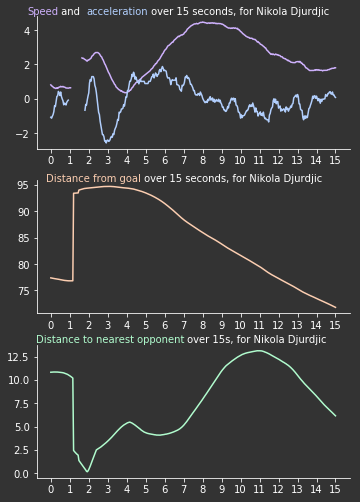

In [859]:
start_frame = 64213
players_to_plot = [40]
for player in players_to_plot:
    plot_speed_acceleration_distance_nearest(home_tracking_with_nearest_teammate, player, start_frame, 
                                             home_players)

In [860]:
64213 / 60 / 25

42.80866666666667

In [854]:
save_movie(64213, 4, 'jitters')

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/jitters.mp4
Generating movie...done


# Pitch Control

We look at pitch control as an additional metric

In [861]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [1023]:
def plot_voronoi(players_position, frame):

#     players_pos_on_pitch = players_position[frame][np.where([x[0] > -155 for x in players_position[frame]])]

    fig, ax = plot_pitch()
    vor = Voronoi(players_position[frame])
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                polygon = [vor.vertices[i] for i in region]
                plt.fill([p[0] for p in polygon], [p[1] for p in polygon], c='k', alpha=0.02 * index)
    plot_frame(home_tracking_with_acceleration.loc[frame], away_tracking_with_acceleration.loc[frame], 
               ball_tracking_data.loc[frame:frame], figax=(fig, ax), team_colors=('g','y'), 
               include_player_velocities=True)
    plt.show()


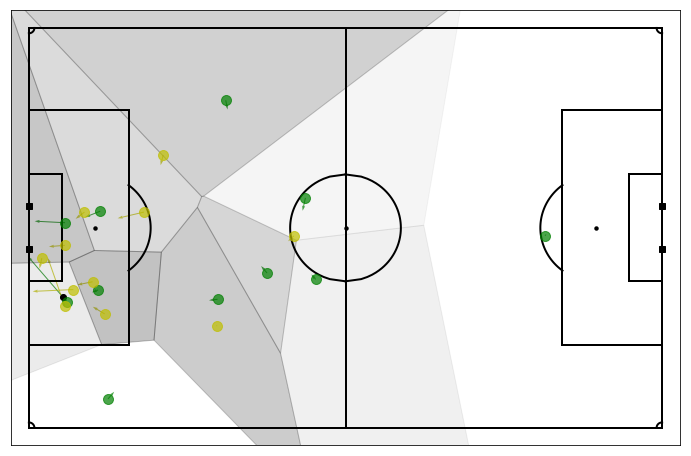

In [1024]:
plot_voronoi(home_players_position, 26829)

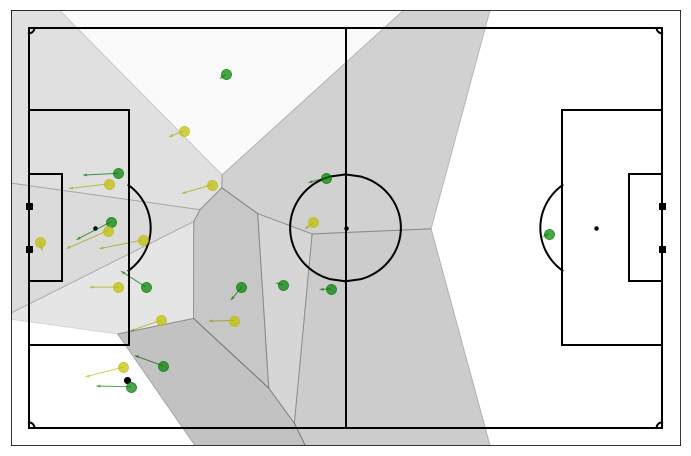

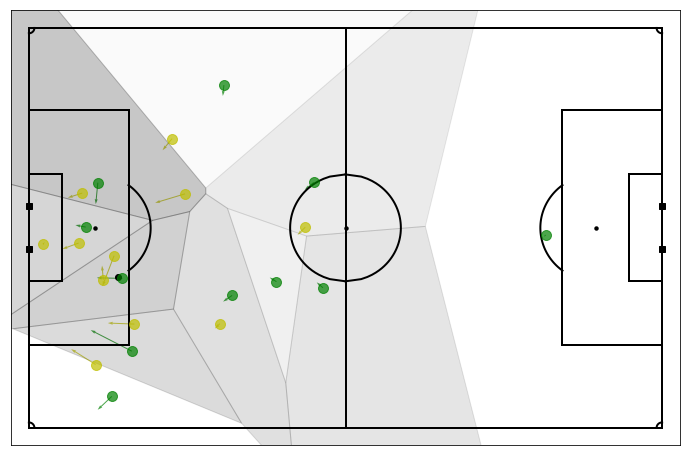

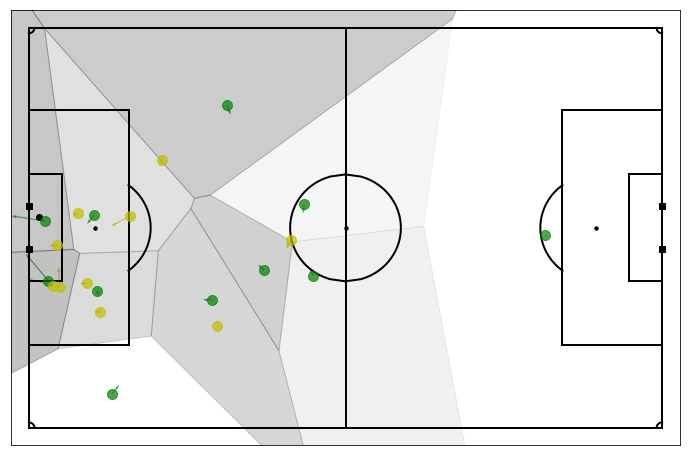

In [1025]:
for frame in [26755, 26782, 26846]:
    plot_voronoi(home_players_position, frame)

In [1248]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 19 14:52:19 2020

Module for calculating a Pitch Control surface using MetricaSports's tracking & event data.

Pitch control (at a given location on the field) is the probability that a team will gain 
possession if the ball is moved to that location on the field. 

Methdology is described in "Off the ball scoring opportunities" by William Spearman:
http://www.sloansportsconference.com/wp-content/uploads/2018/02/2002.pdf

GitHub repo for this code can be found here:
https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

Data can be found at: https://github.com/metrica-sports/sample-data

Functions
----------

calculate_pitch_control_at_target(): calculate the pitch control probability for the attacking and defending teams at a specified target position on the ball.

generate_pitch_control_for_event(): this function evaluates pitch control surface over the entire field at the moment
of the given event (determined by the index of the event passed as an input)

Classes
---------

The 'player' class collects and stores trajectory information for each player required by the pitch control calculations.

@author: Laurie Shaw (@EightyFivePoint)

"""

import numpy as np


def initialise_players(team_data, teamname, params, GKid):
    """
    initialise_players(team,teamname,params)
    
    create a list of player objects that holds their positions and velocities from the tracking data dataframe 
    
    Parameters
    -----------
    
    team: row (i.e. instant) of either the home or away team tracking Dataframe
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returns
    -----------
    
    team_players: list of player objects for the team at at given instant
    
    """    
    # get player  ids
    player_ids = np.unique([c.split('_')[0] for c in team_data.index])
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p, team_data, teamname, params, GKid)
        if team_player.inframe:
            team_players.append(team_player)
    return team_players


def check_offsides(home_players, away_players, attacking_team, ball_position, GK_numbers, verbose=False, tol=0.2):
    """
    check_offsides( attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    
    checks whetheer any of the attacking players are offside (allowing for a 'tol' margin of error). Offside players are removed from 
    the 'attacking_players' list and ignored in the pitch control calculation.
    
    Parameters
    -----------
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_position: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        verbose: if True, print a message each time a player is found to be offside
        tol: A tolerance parameter that allows a player to be very marginally offside (up to 'tol' m) without being flagged offside. Default: 0.2m
            
    Returrns
    -----------
        attacking_players: list of 'player' objects for the players on the attacking team with offside players removed
    """    
    if attacking_team == 'Home':
        attacking_players = home_players.copy()
        defending_players = away_players.copy()
    else:
        attacking_players = away_players.copy()
        defending_players = home_players.copy()
    
    # find jersey number of defending goalkeeper (just to establish attack direction)
    defending_GK_id = str(GK_numbers[1] if attacking_team=='Home' else GK_numbers[0])
    # make sure defending goalkeeper is actually on the field!
    assert defending_GK_id in [p.id for p in defending_players], "Defending goalkeeper jersey number not found in defending players"
    # get goalkeeper player object
    defending_GK = [p for p in defending_players if p.id==defending_GK_id][0]  
    # use defending goalkeeper x position to figure out which half he is defending (-1: left goal, +1: right goal)
    defending_half = np.sign(defending_GK.position[0])
    # find the x-position of the second-deepest defeending player (including GK)
    second_deepest_defender_x = sorted( [defending_half*p.position[0] for p in defending_players], reverse=True )[1]
    # define offside line as being the maximum of second_deepest_defender_x, ball position and half-way line
    offside_line = max(second_deepest_defender_x,defending_half*ball_position[0],0.0)+tol
    # any attacking players with x-position greater than the offside line are offside
    if verbose:
        for p in attacking_players:
            if p.position[0]*defending_half>offside_line:
                print("player %s in %s team is offside" % (p.id, p.playername) )
    attacking_players = [p for p in attacking_players if p.position[0]*defending_half<=offside_line]
    return attacking_players

class player(object):
    """
    player() class
    
    Class defining a player object that stores position, velocity, time-to-intercept and pitch control contributions for a player
    
    __init__ Parameters
    -----------
    pid: id (jersey number) of player
    team: row of tracking data for team
    teamname: team name "Home" or "Away"
    params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
    

    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected time_to_intercept
    
    """
    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self,pid,team,teamname,params,GKid):
        self.id = pid
        self.is_gk = self.id == GKid
        self.teamname = teamname
        self.playername = "%s_" % (pid)
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_def = params['lambda_gk'] if self.is_gk else params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array([team[self.playername+'x'], team[self.playername+'y']])
        self.inframe = not np.any( [pos < -150 for pos in self.position] )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

""" Generate pitch control map """

def default_model_params(time_to_control_veto=3):
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['lambda_gk'] = params['lambda_def']*3.0 # make goal keepers must quicker to control ball (because they can catch it)
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

def generate_pitch_control_for_frame(frame, attacking_team, tracking_home, tracking_away,
                                     tracking_ball, params, GK_numbers, field_dimen=(104.6,68.4,), 
                                     n_grid_cells_x = 50, offsides=True):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        offsides: If True, find and remove offside atacking players from the calculation. Default is True.
        
    UPDATE (tutorial 4): Note new input arguments ('GK_numbers' and 'offsides')
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)

    """
    # get the details of the event (frame, team in possession, ball_start_position)
    
    ball_start_pos = np.array([tracking_ball.loc[frame]['ball_x'],tracking_ball.loc[frame]['ball_y']])
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if attacking_team=='Home':
        attacking_players = initialise_players(tracking_home.loc[frame],'Home',params,GK_numbers[0])
        defending_players = initialise_players(tracking_away.loc[frame],'Away',params,GK_numbers[1])
    elif attacking_team=='Away':
        defending_players = initialise_players(tracking_home.loc[frame],'Home',params,GK_numbers[0])
        attacking_players = initialise_players(tracking_away.loc[frame],'Away',params,GK_numbers[1])
    else:
        assert False, "Team in possession must be either home or away"
        
    # find any attacking players that are offside and remove them from the pitch control calculation
    if offsides:
        attacking_players = check_offsides( attacking_players, defending_players, attacking_team, ball_start_pos, GK_numbers)
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid

def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )

    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the atetacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

In [1136]:
def plot_pitchcontrol_for_event(frame, tracking_home, tracking_away, ball, PPCF, attacking_team='Home',
                                alpha = 0.7, include_player_velocities=True,
                                annotate=False, field_dimen = (104.6,68.4), team_colors=('g', 'y')):
    """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF )
    
    Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    NB: this function no longer requires xgrid and ygrid as an input
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """    
    
    # plot frame and event
    fig,ax = plot_pitch(field_color='white', field_dimen = field_dimen)
    if attacking_team=='Home':
        c = mcolors.ColorConverter().to_rgb
        cmap = make_colormap(
            [c(team_colors[1]), c('white'), 0.5, c('white'), c(team_colors[0])])
    else:
        cmap = make_colormap(
            [c(team_colors[0]), c('white'), 0.5, c('white'), c(team_colors)])
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., 
                                       field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,
              cmap=cmap,alpha=0.2)
    plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], ball.loc[frame:frame], 
               figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate,
               team_colors=team_colors)

    return fig,ax

In [1119]:
params = default_model_params()
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(26782, 'Home', home_tracking_with_speed, 
                                                    away_tracking_with_speed, ball_tracking_data, 
                                                    params, GK_numbers=[25,1], offsides=True)

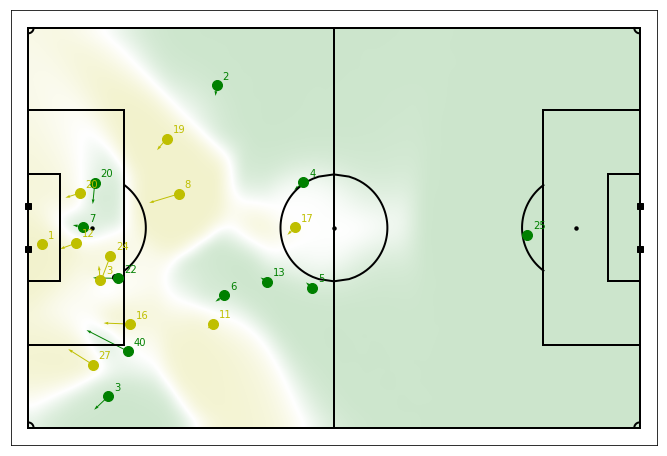

(<matplotlib.figure.Figure at 0x13f9e923780>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f9fc90b38>)

In [1137]:
plot_pitchcontrol_for_event(26782, home_tracking_with_speed, away_tracking_with_speed, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=('g','y'), alpha=1)

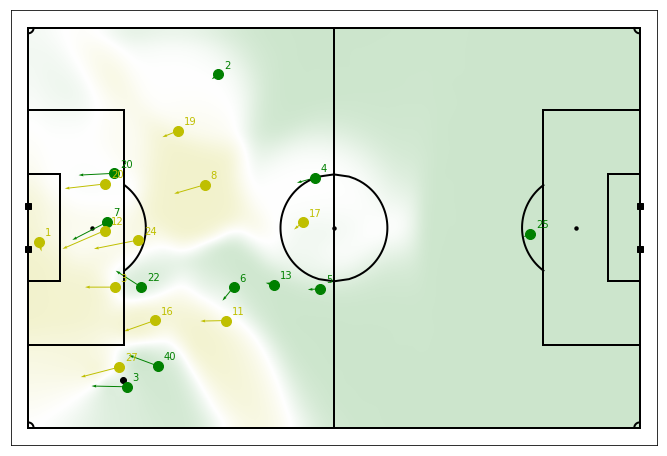

(<matplotlib.figure.Figure at 0x13fd198bba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fa189e5f8>)

In [1138]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(26755, 'Home', home_tracking_with_speed, 
                                                    away_tracking_with_speed, ball_tracking_data, 
                                                    params, GK_numbers=[25,1], offsides=True)
plot_pitchcontrol_for_event(26755, home_tracking_with_speed, away_tracking_with_speed, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=('g','y'), alpha=1)

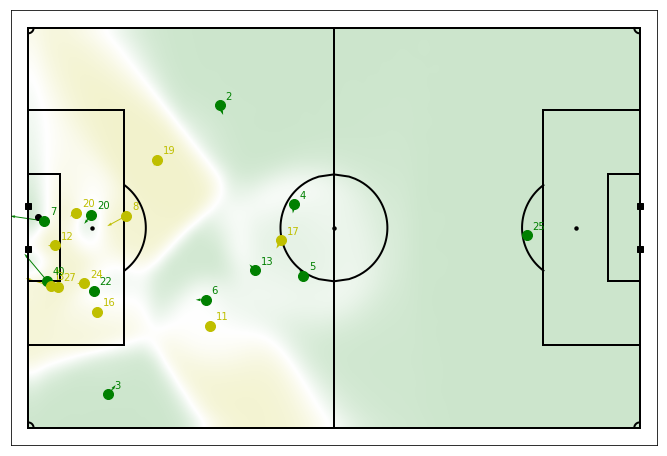

(<matplotlib.figure.Figure at 0x13f9d504278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f8629bba8>)

In [1139]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(26846, 'Home', home_tracking_with_speed, 
                                                    away_tracking_with_speed, ball_tracking_data, 
                                                    params, GK_numbers=[25,1], offsides=False)
plot_pitchcontrol_for_event(26846, home_tracking_with_speed, away_tracking_with_speed, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=('g','y'), alpha=1)

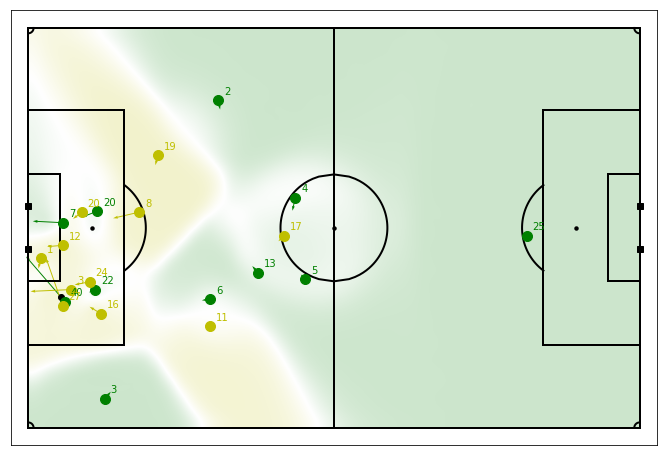

(<matplotlib.figure.Figure at 0x13fa13929e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f9e7dccf8>)

In [1140]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(26829, 'Home', home_tracking_with_speed, 
                                                    away_tracking_with_speed, ball_tracking_data, 
                                                    params, GK_numbers=[25,1], offsides=True)
plot_pitchcontrol_for_event(26829, home_tracking_with_speed, away_tracking_with_speed, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=('g','y'), alpha=1)

In [1135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    
    Taken from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

# Runs of Rodic

1. Makes a shot on 21m16s after a burst of pace into the area against Malmo
2. Runs full length of field on 25m25s and has presence of mind to drift away from defender to find space in box
3. Look at pass on 28m33s - movement from Djurdjic to create space for Rodic
4. Run in 7th minute vs Malmo to get into crossing position
5. Goal against Orebro on 38m56s - really solid run into box to meet cross
6. 48m25s comes out wide, pulling defender with him. Creates a large amount of space between centre back pair and wing which number 2 is able to run into

In [1185]:
def get_tracking_data_with_metrics(home_team_tracking_data, away_team_tracking_data):
    home_tracking_with_speed = calc_player_velocities(home_team_tracking_data, filter_type='moving_average')
    away_tracking_with_speed = calc_player_velocities(away_team_tracking_data, filter_type='moving_average')
    home_tracking_with_acceleration = calculate_acceleration(home_tracking_with_speed,
                                                             filter_type='moving_average')
    away_tracking_with_acceleration = calculate_acceleration(away_tracking_with_speed,
                                                             filter_type='moving_average')
    home_tracking_with_distance_to_goal = calculate_distance_to_goal(home_tracking_with_acceleration,
                                                                     left_to_right=False)
    away_tracking_with_distance_to_goal = calculate_distance_to_goal(away_tracking_with_acceleration,
                                                                     left_to_right=True)
    home_tracking_with_nearest_opposition = calculate_distance_to_nearest_oppostion_player(home_tracking_with_distance_to_goal,
                                                                                         away_tracking_with_distance_to_goal)
    away_tracking_with_nearest_opposition = calculate_distance_to_nearest_oppostion_player(away_tracking_with_distance_to_goal,
                                                                                         home_tracking_with_distance_to_goal)
    home_tracking_with_nearest_teammate = calculate_distance_to_nearest_teammate(home_tracking_with_nearest_opposition)
    away_tracking_with_nearest_teammate = calculate_distance_to_nearest_teammate(away_tracking_with_nearest_opposition)
    
    return home_tracking_with_nearest_teammate, away_tracking_with_nearest_teammate

In [1194]:
def get_data_for_half_of_game(file_name, half_to_get_data_for, home_team_name, away_team_name):
    year = file_name[:4]
    data_file_name = f'{file_name}.{half_to_get_data_for}'

    #Preprocesses the file in to the format we use.
    [ball_position_not_transf,players_position_not_transf,players_team_id,events,players_jersey,
     info_match,names_of_players] = LoadDataHammarbyNewStructure2020(data_file_name, 'Signality/2019/Tracking Data/')

    players_in_play = GetPlayersInPlay(players_position_not_transf,frame)

    players_position, ball_position = transform_coords(players_position_not_transf,
                                                       ball_position_not_transf)
    
    team_index = players_team_id[0].astype(int).reshape(len(players_team_id[0]),)
    
    # Get player jersey to name dictionary for each team
    home_players = {jersey: name for jersey, name in zip(players_jersey[team_index==2], 
                                                         np.array(names_of_players)[team_index==2])}
    away_players = {jersey: name for jersey, name in zip(players_jersey[team_index==7], 
                                                         np.array(names_of_players)[team_index==7])}

    home_team_tracking_data, away_team_tracking_data, ball_tracking_data = get_tracking_data_in_dataframes(players_position, 
                                                                                                           players_jersey, 
                                                                                                           team_index, 
                                                                                                           ball_position)
    
    home_tracking_with_metrics, away_tracking_with_metrics = get_tracking_data_with_metrics(home_team_tracking_data, 
                                                                                        away_team_tracking_data)
    
    return home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, home_players, away_players

In [1218]:
file_name = '20191020.Hammarby-MalmöFF'
half_to_get_data_for = 1
#Names of the teams playing in OPTA format
home_team_name = 'Hammarby IF'
away_team_name = 'Malmö FF'

[home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, 
 home_players, away_players] = get_data_for_half_of_game(file_name, half_to_get_data_for, home_team_name, away_team_name)

Loading data, this might take some seconds...
Data has been loaded


In [1205]:
def save_movie(start_frame, home_tracking_with_speed, away_tracking_with_speed, 
               ball_tracking_data, clip_length, file_name, fpath):
    end_frame = start_frame + clip_length * 25
    save_match_clip(home_tracking_with_speed[start_frame:end_frame], 
                    away_tracking_with_speed[start_frame:end_frame], 
                    ball_tracking_data[start_frame:end_frame], 
                    fpath=fpath, include_player_velocities=False,
                    fname=file_name)

In [1225]:
#Makes a shot on 21m16s after a burst of pace into the area against Malmo
#Runs full length of field on 25m25s and has presence of mind to drift away from defender to find space in box
#Look at pass on 28m33s - movement from Djurdjic to create space for Rodic
#Run in 7th minute vs Malmo to get into crossing position

In [1222]:
# Makes a shot on 21m16s after a burst of pace into the area against Malmo
start_minute = 21
start_seconds = 5
length_of_clip = 30
file_name = 'shot_in_22nd_min'
fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data'
save_movie(start_minute * 60 * 25 + start_seconds * 25, home_tracking_with_metrics,
           away_tracking_with_metrics, ball_tracking_data, length_of_clip,
           file_name, fpath)

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/shot_in_22nd_min.mp4
Generating movie...done


In [1234]:
# 7 or 8 seconds into this the run is made
21 * 60 * 25 + 12 * 25

31800

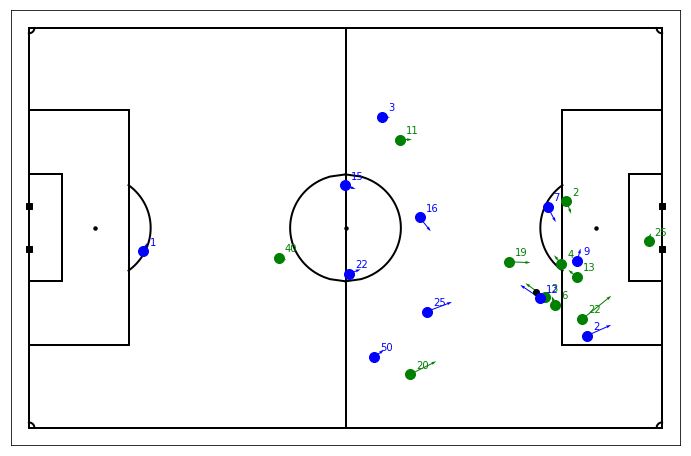

(<matplotlib.figure.Figure at 0x1402161b390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14021c429e8>)

In [1335]:
frame_to_plot = 31780

plot_frame(home_tracking_with_metrics.loc[frame_to_plot], away_tracking_with_metrics.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

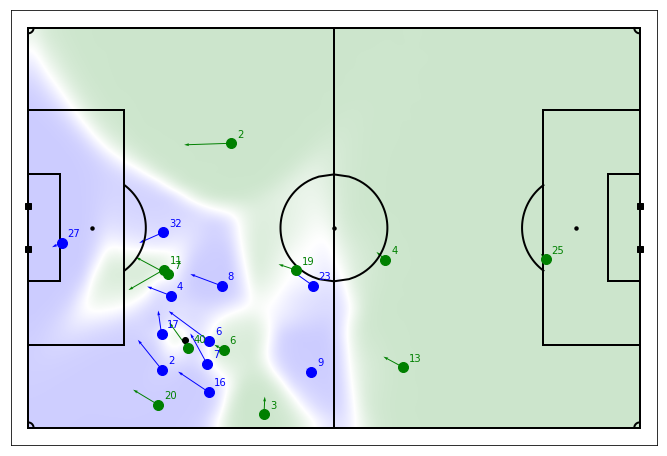

(<matplotlib.figure.Figure at 0x13fea658438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fea4467f0>)

In [1254]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(frame_to_plot, 'Home', home_tracking_with_metrics, 
                                                    away_tracking_with_metrics, ball_tracking_data, 
                                                    params, GK_numbers=[25,27], offsides=True)
plot_pitchcontrol_for_event(frame_to_plot, home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=(color_home, color_away), alpha=1)

In [1263]:
def plot_distance_to_nearest_player(team_data, player_to_plot, start_frame, player_lookup,
                                    nearest_player_for_frame, opponent_or_teammate='opponent', 
                                    seconds_to_plot=15, y_axis_limits=None):
    """
    Produce a speed acceleration plot and a distance from goal plot for given player in 
    team, given a start frame and number of seconds to plot
    """
    
    end_frame = start_frame + 25 * seconds_to_plot + 1
    player_name = player_lookup[int(player_to_plot)]
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    fig.set_facecolor('#333333')
    ax.set_facecolor('#333333')
    ax.spines["bottom"].set_color("white")
    ax.spines["left"].set_color("white")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    ax.plot(range(start_frame, end_frame), 
            team_data[start_frame : end_frame][f'{player_to_plot}_distance_to_nearest_{opponent_or_teammate}'],
            color='#b1fcce')
    
#     fig.text(0.5, 0.95, f"Distance to nearest {opponent_or_teammate}", ha="right", va="bottom", fontsize='large', color="#b1fcce")
#     fig.text(0.5, 0.95, f" over 15s, for {player_name}", ha="left", va="bottom", fontsize='large', color='white')
    ax.set_title(f'Distance between {player_name} and {nearest_player_for_frame}',
                  color='white')
    ax.set_xticks(range(start_frame, end_frame, 25))
    ax.set_xticklabels(range(0, seconds_to_plot + 1))
    if y_axis_limits:
        ax.set_ylim(y_axis_limits[0], y_axis_limits[1])
    
    fig.tight_layout()
    
    plt.show()

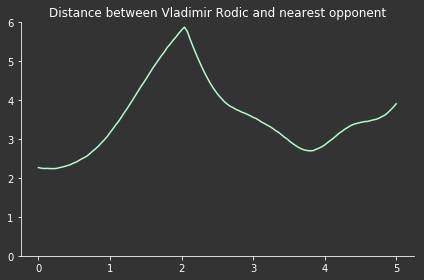

In [1266]:
plot_distance_to_nearest_player(home_tracking_with_metrics, 11, 31780, home_players, 'nearest opponent',
                                opponent_or_teammate='opponent', seconds_to_plot=5,
                                y_axis_limits=(0, 6))

In [1267]:
# Runs full length of field on 25m25s and has presence of mind to drift away from defender to find space in box
start_minute = 25
start_seconds = 15
length_of_clip = 30
file_name = 'run_in_25th_min'
fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data'
save_movie(start_minute * 60 * 25 + start_seconds * 25, home_tracking_with_metrics,
           away_tracking_with_metrics, ball_tracking_data, length_of_clip,
           file_name, fpath)

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/run_in_25th_min.mp4
Generating movie...done


In [1271]:
# Run in 7th minute vs Malmo to get into crossing position
# Runs full length of field on 25m25s and has presence of mind to drift away from defender to find space in box
start_minute = 6
start_seconds = 20
length_of_clip = 20
file_name = 'run_in_7th_min'
fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data'
save_movie(start_minute * 60 * 25 + start_seconds * 25, home_tracking_with_metrics,
           away_tracking_with_metrics, ball_tracking_data, length_of_clip,
           file_name, fpath)

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/run_in_7th_min.mp4
Generating movie...done


In [1272]:
6 * 25 * 60 + 32 * 25

9800

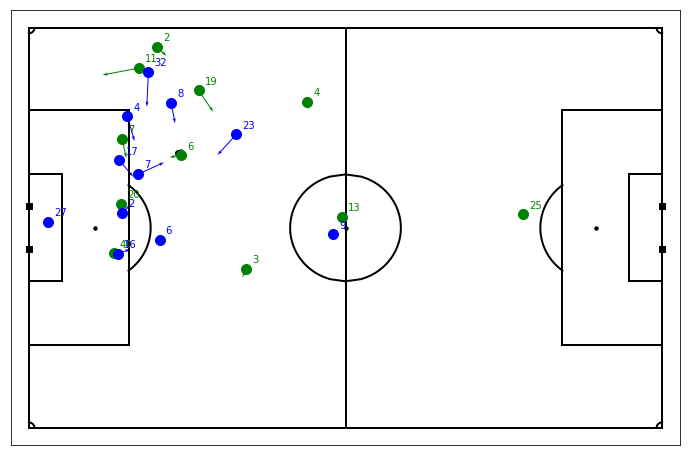

(<matplotlib.figure.Figure at 0x13f9c3f8518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13fecb2f278>)

In [1292]:
# 12 seconds into this clip run made
frame_to_plot = 9795

plot_frame(home_tracking_with_metrics.loc[frame_to_plot], away_tracking_with_metrics.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

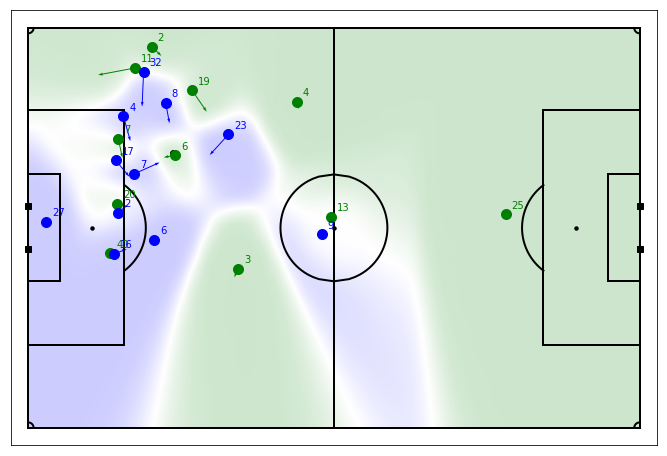

(<matplotlib.figure.Figure at 0x13ffcad57f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ffa5d9cf8>)

In [1293]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(frame_to_plot, 'Home', home_tracking_with_metrics, 
                                                    away_tracking_with_metrics, ball_tracking_data, 
                                                    params, GK_numbers=[25,27], offsides=True)
plot_pitchcontrol_for_event(frame_to_plot, home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=(color_home, color_away), alpha=1)

In [1296]:
file_name = '20190930.Hammarby-Örebrö'
half_to_get_data_for = 1
#Names of the teams playing in OPTA format
home_team_name = 'Hammarby IF'
away_team_name = 'Örebro SK'

[home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, 
 home_players, away_players] = get_data_for_half_of_game(file_name, half_to_get_data_for, home_team_name, away_team_name)

Loading data, this might take some seconds...
Data has been loaded


In [1297]:
# Goal against Orebro on 38m56s - really solid run into box to meet cross
start_minute = 38
start_seconds = 30
length_of_clip = 30
file_name = 'goal_in_38th_min'
fpath='C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data'
save_movie(start_minute * 60 * 25 + start_seconds * 25, home_tracking_with_metrics,
           away_tracking_with_metrics, ball_tracking_data, length_of_clip,
           file_name, fpath)

C:/Users/nobor/Documents/O/Programming/football_analytics/projects/using_tracking_data/goal_in_38th_min.mp4
Generating movie...done


In [1299]:
# The run Rodic makes in 21 - 22 seconds into this clip
38 * 25 * 60 + 25 * 51

58275

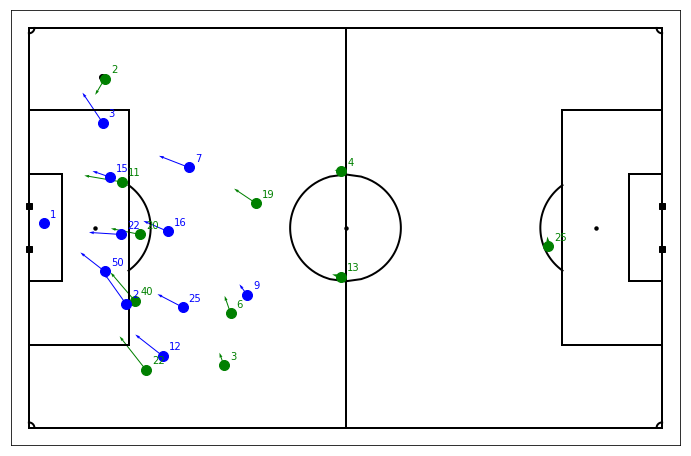

(<matplotlib.figure.Figure at 0x140224f7710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1402242b7b8>)

In [1341]:
# 12 seconds into this clip run made
frame_to_plot = 58291

plot_frame(home_tracking_with_metrics.loc[frame_to_plot], away_tracking_with_metrics.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)

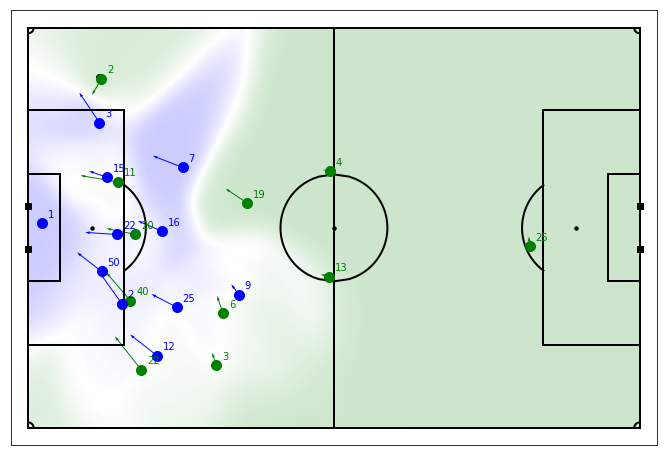

(<matplotlib.figure.Figure at 0x140225a50f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14022693d30>)

In [1342]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(frame_to_plot, 'Home', home_tracking_with_metrics, 
                                                    away_tracking_with_metrics, ball_tracking_data, 
                                                    params, GK_numbers=[25,1], offsides=True)
plot_pitchcontrol_for_event(frame_to_plot, home_tracking_with_metrics, away_tracking_with_metrics, ball_tracking_data, 
                            PPCF, attacking_team='Home', annotate=True, team_colors=(color_home, color_away), alpha=1)

In [1343]:
home_players

{2: 'Simon Sandberg',
 3: 'Dennis Widgren',
 4: 'Richard Magyar',
 6: 'Darijan Bojanic',
 11: 'Vladimir Rodic',
 13: 'Mads Fenger Nielsen',
 14: 'Tim Söderström',
 16: 'Leo Bengtsson',
 19: 'Serge-Junior Martinsson Ngouali',
 20: 'Alexander Kacaniklic',
 22: 'Muamer Tankovic',
 24: 'Oliver Dovin',
 25: 'Davor Blazevic',
 26: 'Kalle Björklund',
 31: 'Aimar Sher',
 32: 'André Alsanati',
 40: 'Nikola Djurdjic',
 77: 'Mats Goberg Solheim'}

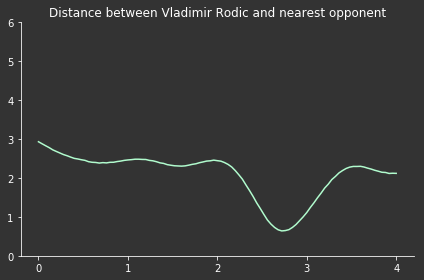

In [1332]:
plot_distance_to_nearest_player(home_tracking_with_metrics, 11, 58235, home_players, 'nearest opponent',
                                opponent_or_teammate='opponent', seconds_to_plot=4,
                                y_axis_limits=(0, 6))

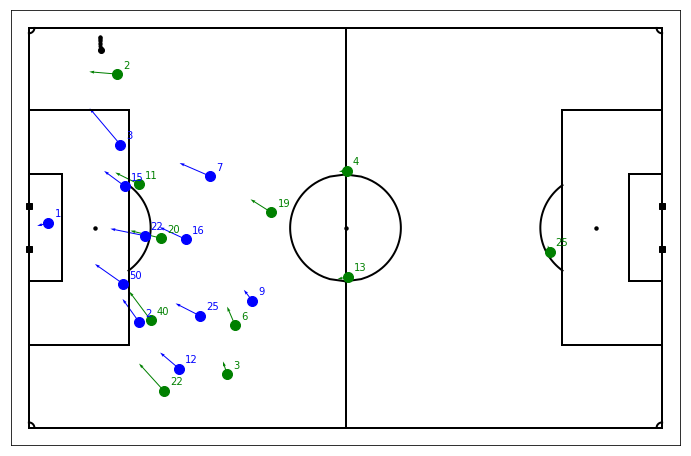

(<matplotlib.figure.Figure at 0x1402122dc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1402157b2e8>)

In [1334]:
# 12 seconds into this clip run made
frame_to_plot = 58270

plot_frame(home_tracking_with_metrics.loc[frame_to_plot], away_tracking_with_metrics.loc[frame_to_plot], 
           ball_tracking_data.loc[frame_to_plot - 10: frame_to_plot], 
           team_colors=(color_home, color_away), annotate=True, PlayerAlpha=1, 
           include_player_velocities=True)